# Taming the black-box: Creating intelligible boosted trees models

Repository: https://github.com/samathizer/boosted-trees

Bring logic into boosted trees models by

1. interaction constraints, and/or
2. monotonic constraints.

**Such constraints slightly reduce performance, but can greatly improve interpretability and usability.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

- Motor third-part liability (MTPL) pricing dataset.
- 1 Mio insurance policies and their corresponding claim counts.
- Will model claim counts (`claim_nb`) as function of all other columns $X$, in math:
$$
    \log(E(\text{claim\_nb} \mid X = x)) = f(x)
$$
- Synthetically generated via Copulas. True model known.
- Available from [this link](https://www.openml.org/search?type=data&status=active&id=45106) on OpenML, or as parquet file in repo.

*Reference*

>Michael Mayer, Daniel Meier, and Mario Wüthich (2023).
>SHAP for Actuaries: Explain any Model. 
>http://dx.doi.org/10.2139/ssrn.4389797. 

In [2]:
if False:  # Fetch from OpenML
    from sklearn.datasets import fetch_openml
    
    df0 = fetch_openml(data_id=45106, as_frame=True)
    df = df0.data
    df["claim_nb"] = df0.target
else:     # Fetch from repo
    df = pd.read_parquet("df.parquet")
df

,year,town,driver_age,car_weight,car_power,car_age,claim_nb
0,2018.0,1.0,51.0,1760.0,173.0,3.0,0
1,2019.0,1.0,41.0,1760.0,248.0,2.0,0
2,2018.0,1.0,25.0,1240.0,111.0,2.0,0
3,2019.0,0.0,40.0,1010.0,83.0,9.0,0
4,2018.0,0.0,43.0,2180.0,169.0,5.0,0
...,...,...,...,...,...,...,...
999995,2019.0,1.0,45.0,1090.0,62.0,2.0,0
999996,2019.0,1.0,45.0,1180.0,93.0,4.0,0
999997,2018.0,1.0,31.0,1060.0,57.0,1.0,0
999998,2019.0,1.0,28.0,1910.0,149.0,0.0,0


## Describe data

1. Univariately
2. Rank-correlations

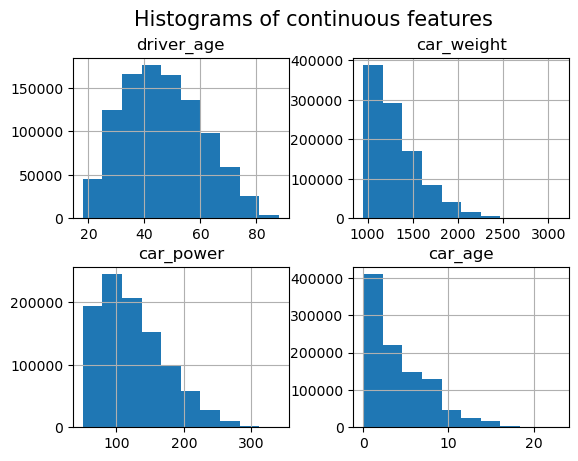

In [3]:
df.hist(["driver_age", "car_weight", "car_power", "car_age"])
_ = plt.suptitle("Histograms of continuous features", fontsize=15)

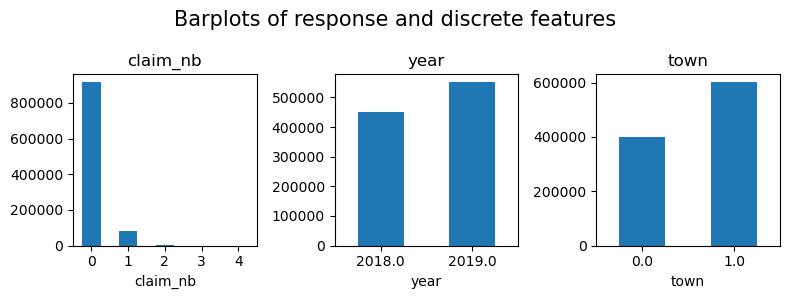

In [4]:
fig, axes = plt.subplots(figsize=(8, 3), ncols=3)

for v, ax in zip(["claim_nb", "year", "town"], axes):
    df[v].value_counts(sort=False).sort_index().plot(kind="bar", ax=ax, rot=0, title=v)
plt.suptitle("Barplots of response and discrete features", fontsize=15)
plt.tight_layout()

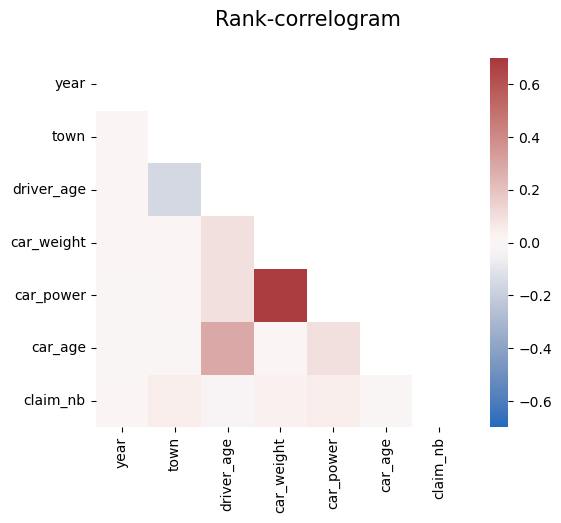

In [5]:
corr = df.corr("spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.suptitle("Rank-correlogram", fontsize=15)
_ = sns.heatmap(
    corr, mask=mask, vmin=-0.7, vmax=0.7, center=0, cmap="vlag", square=True
)

## Data split

In [6]:
from sklearn.model_selection import train_test_split

y_train, y_test, X_train, X_test = train_test_split(
    df["claim_nb"], df.drop("claim_nb", axis=1), test_size=0.1, random_state=30
)

## Unconstrained model

- LightGBM model using Poisson deviance loss.
- Number of trees via early stopping on CV performance.
- Other parameters manually via CV.

In [7]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

dtrain = lgb.Dataset(X_train, label=y_train)

### Parameter tuning

In [8]:
params = dict(
    learning_rate=0.05,
    objective="poisson",
    metric="poisson",
    num_leaves=7,
    min_child_samples=50,
    min_child_weight=0.001,
    colsample_bynode=0.8,
    subsample=0.8,
    reg_alpha=3,
    reg_lambda=5,
    verbose=-1,
)

if False:  # Set to True to re-run CV
    cvm = lgb.cv(
        params=params,
        train_set=dtrain,
        num_boost_round=2000,
        nfold=5,
        callbacks=[lgb.log_evaluation(period=10), lgb.early_stopping(20, verbose=0)],
    )

    num_rounds = len(cvm["valid poisson-mean"])
    num_rounds, cvm["valid poisson-mean"][num_rounds - 1]
else:
    num_rounds = 360

### Fit with best parameters

In [9]:
model = LGBMRegressor(n_estimators=num_rounds, **params)
_ = model.fit(X_train, y_train)

### SHAP analysis

- Decompose 2000 training observations via TreeSHAP.
- Note: SHAP values are on "raw" scale (here log due to Poisson loss).

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


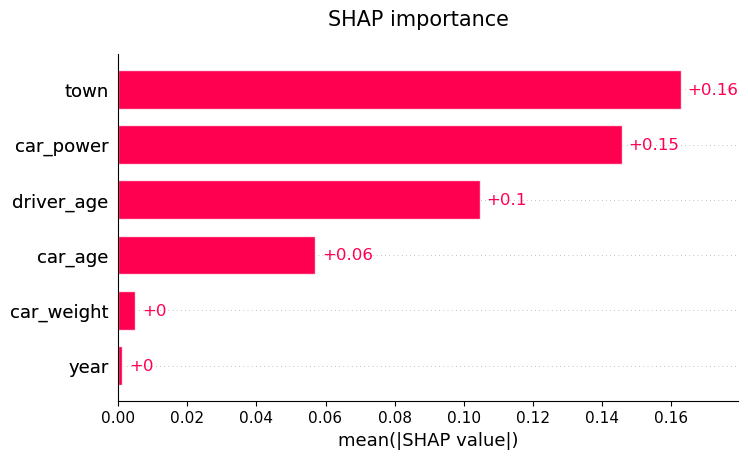

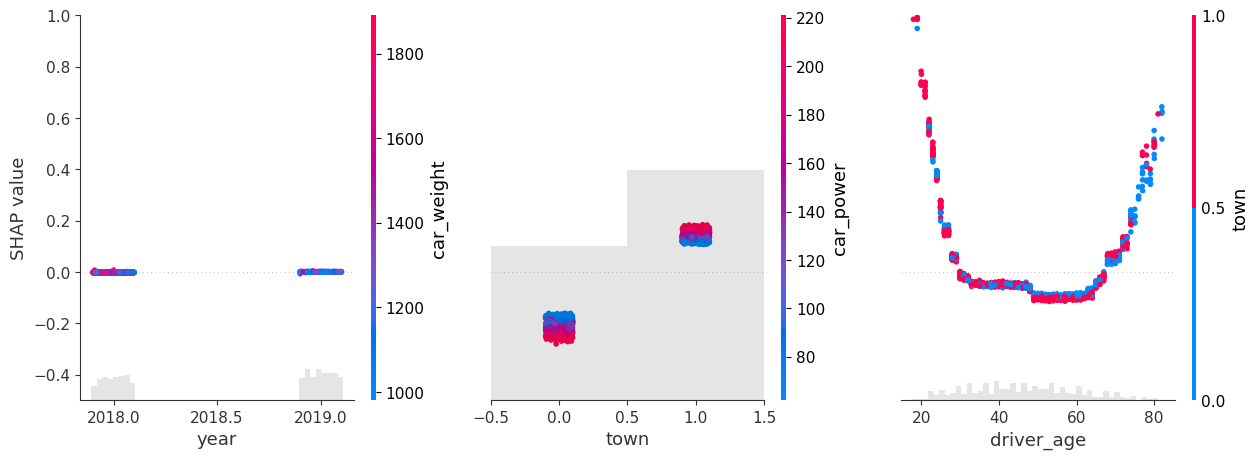

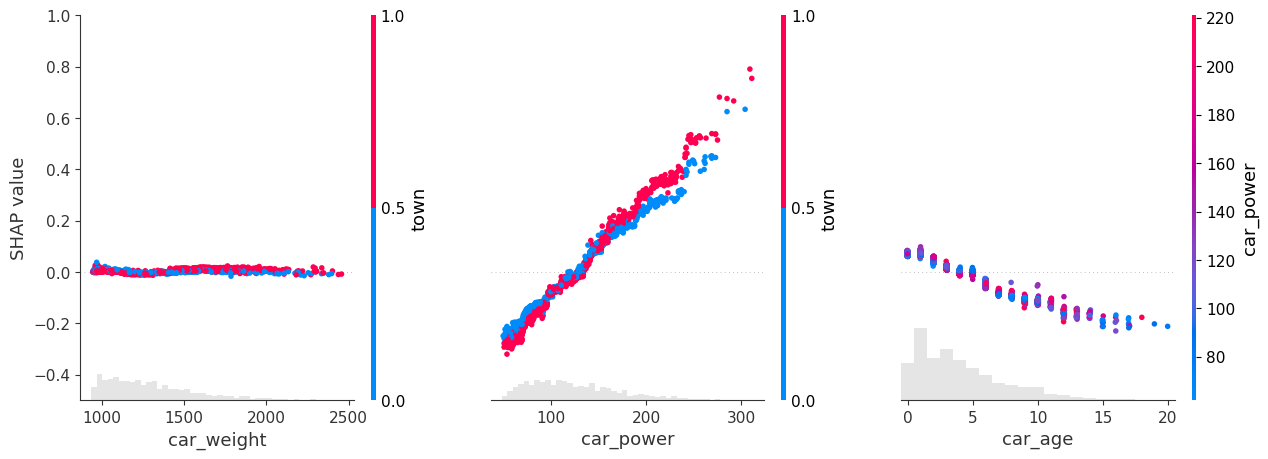

In [10]:
import shap

X_explain = X_train.sample(n=2000, random_state=937)
explainer = shap.Explainer(model)
shap_val = explainer(X_explain)

plt.suptitle("SHAP importance", fontsize=15)
shap.plots.bar(shap_val)

for s in [shap_val[:, 0:3], shap_val[:, 3:]]:
    shap.plots.scatter(s, color=shap_val, ymin=-0.5, ymax=1)

**Comments**

- `year` and `car_weight` almost no effect.
- Visible interaction between `car_power` and `town`.
- Highly non-linear `driver_age` effect.

### ICE and PDP

- ICE: Individual conditional expectation.
- PDP: Partial dependence plot (= average ICE).
- Work on log scale -> class `LogRegressor`.
- Use *centered* version.

In [11]:
from sklearn.base import RegressorMixin
from sklearn.utils.validation import check_is_fitted


class LogRegressor(RegressorMixin):
    """
    A wrapper class for a Scikit-Learn regressor that evaluates predictions on a log scale.

    Parameters
    ----------
    regressor : object
        A Scikit-Learn regressor object that has already been fit to data.
    
    Methods
    -------
    predict(X)
        Make predictions for the given input data X.

    fit(*args, **kwargs)
        Not used.
    """
    def __init__(self, estimator):
        self._estimator = estimator
        check_is_fitted(self._estimator)
        self.is_fitted_ = True

    def fit(self, *args, **kwargs):
        return self

    def predict(self, X):
        return np.log(self._estimator.predict(X))

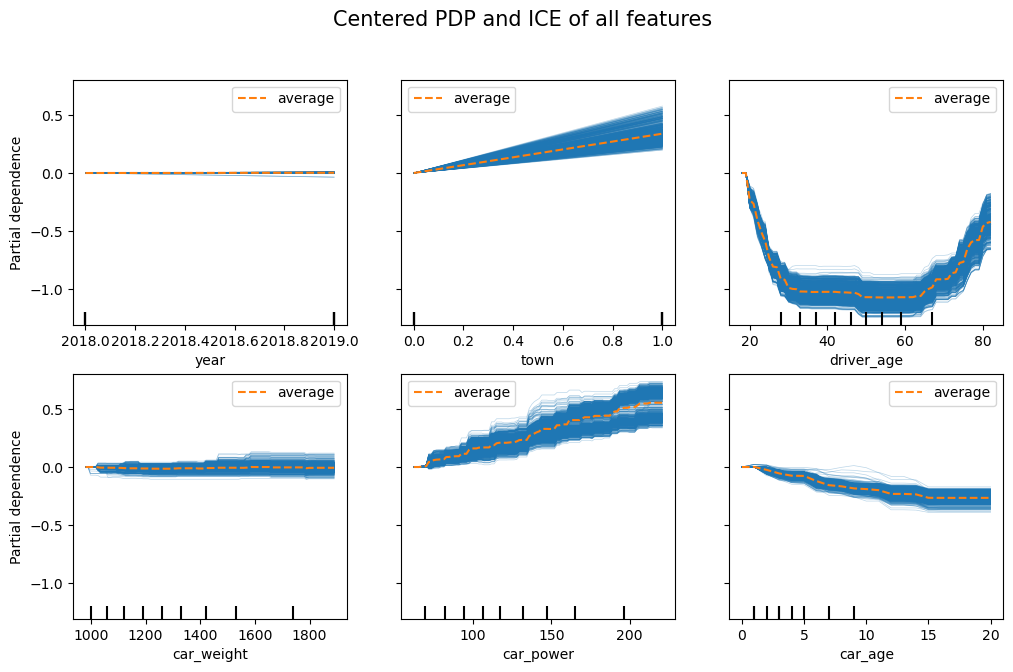

In [12]:
from sklearn.inspection import PartialDependenceDisplay

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle("Centered PDP and ICE of all features", fontsize=15)

_= PartialDependenceDisplay.from_estimator(
    LogRegressor(model), 
    X=X_explain, 
    features=X_explain.columns, 
    kind="both", 
    centered=True,
    ax=axes,
)

**Comment:** Quite similar insights as with SHAP, but less info about interaction.

## Interaction constraints

**Main reason:** Some features additively for maximal interpretability, other features with interactions for maximal performance.

- Specify: What feature sets are allowed to interact, i.e., may appear in same branch?
- Example: `interaction_constraints=[[0], [2], [5], [1, 3, 4]]`
  - Features `year` (0), `driver_age` (2), `car_age` (5) are additive (no interactions).
  - Features 1, 3, 4 may interact.
  - Additive `year` effect makes sense from business perspective, the other two features are for illustration only.
- To be additive in *all features*, set `max_depth = 1` instead.

### Let's implement above example

- For simplicity, use same hyper-parameters. 
- In practice, more boosting rounds required to compensate for suppressed interactions.

In [13]:
params_ic = params | {"interaction_constraints": [[0], [2], [5], [1, 3, 4]]}

model_ic = LGBMRegressor(n_estimators=num_rounds, **params_ic)
_ = model_ic.fit(X_train, y_train)

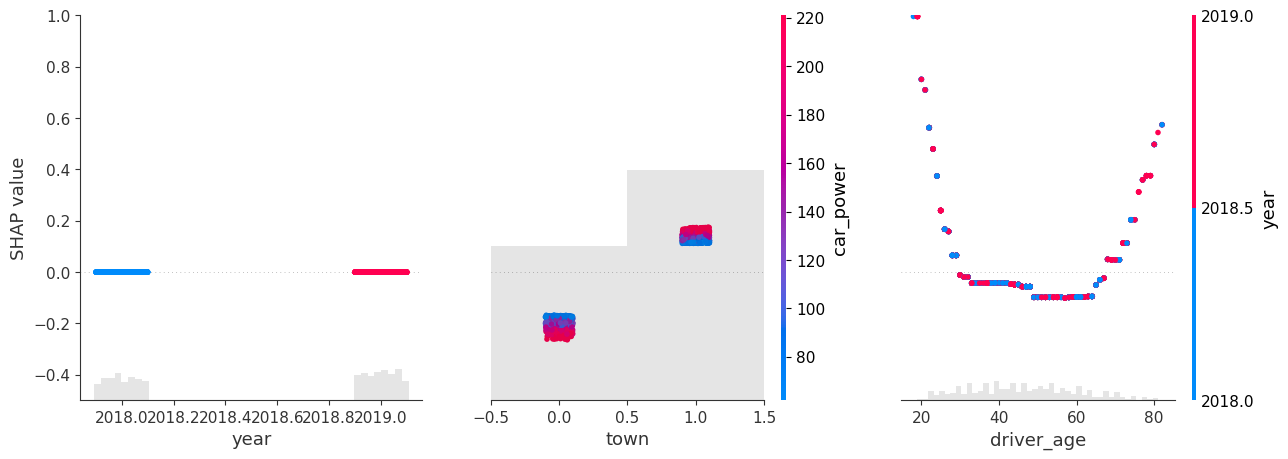

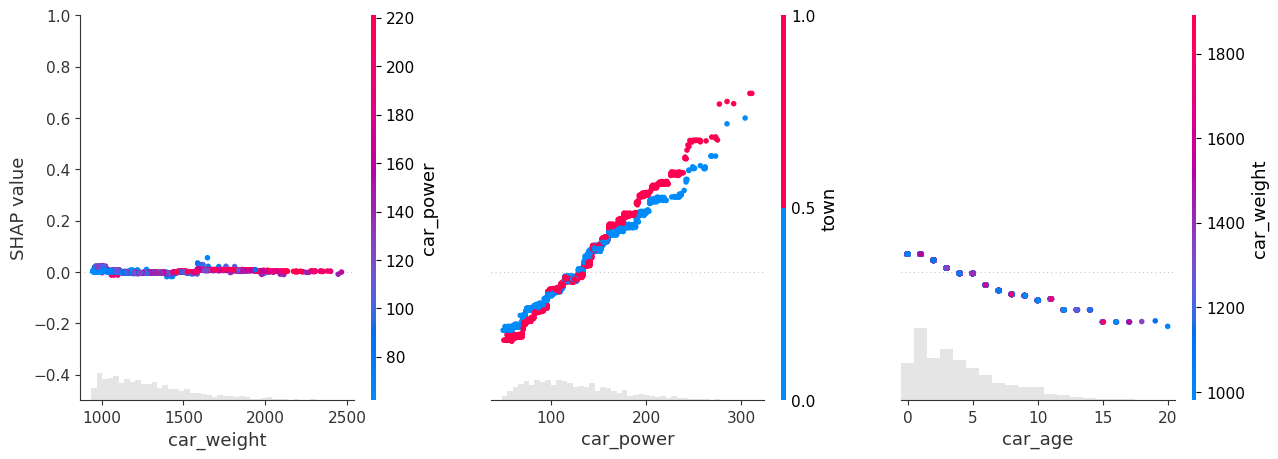

In [14]:
explainer_ic = shap.Explainer(model_ic)
shap_val_ic = explainer_ic(X_explain)

for s in [shap_val_ic[:, 0:3], shap_val_ic[:, 3:]]:
    shap.plots.scatter(s, color=shap_val_ic, ymin=-0.5, ymax=1)

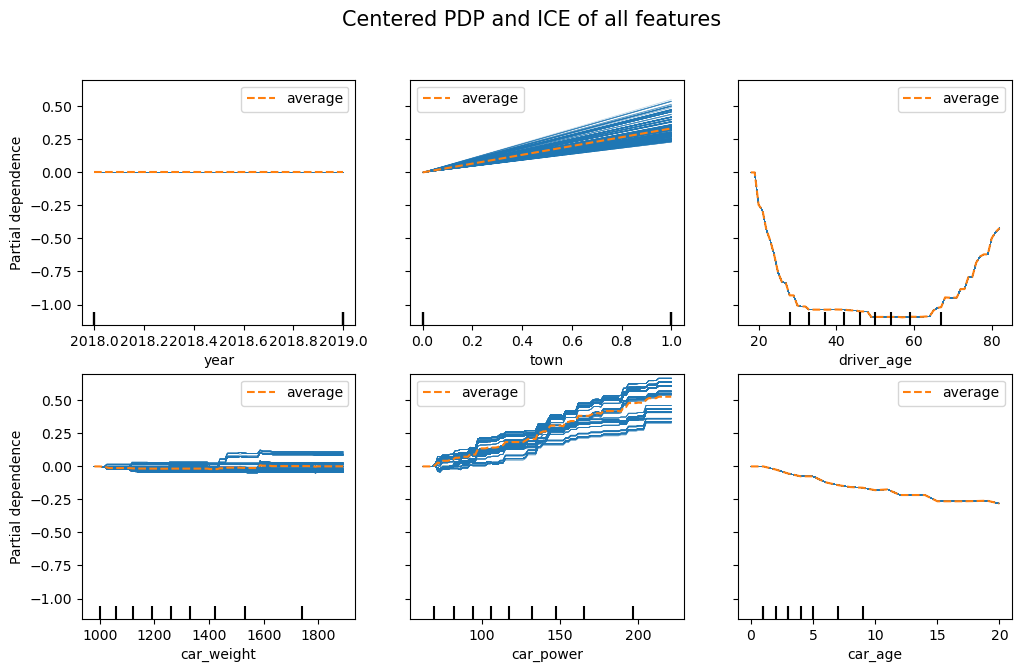

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle("Centered PDP and ICE of all features", fontsize=15)

_= PartialDependenceDisplay.from_estimator(
    LogRegressor(model_ic), 
    X=X_explain, 
    features=X_explain.columns, 
    kind="both", 
    centered=True,
    ax=axes,
)

**Comments regarding `year`, `driver_age` and `car_age`**

- SHAP dependence: No vertical scatter visible anymore.
- Centered ICE: All curves agree.
- SHAP dependence = PDP evaluated on all values (up to shift).

Constraints seem to work.

## Monotone constraints

**Main reason** 
- Predictions should be monotonic in a feature $X_j$, Ceteris Paribus.
- And: Reduce wiggliness of predictions in such $X_j$.

### Example

The ICE curves of `car_power` and `car_age` are *almost* monotonic. Even if it does not make 100% sense from business perspective, we will now model them *perfectly* monotonic for illustration.

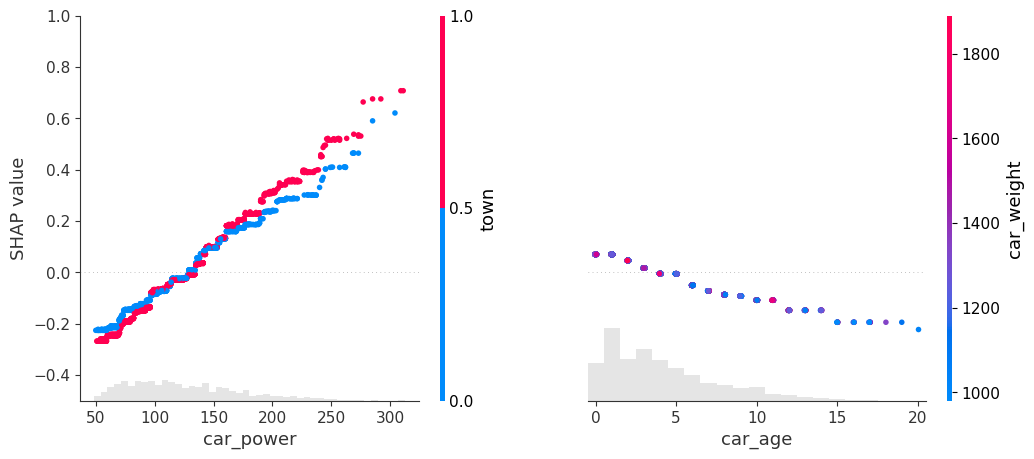

In [16]:
params_mc = params_ic | {"monotone_constraints": [0, 0, 0, 0, 1, -1]}

model_mc = LGBMRegressor(n_estimators=num_rounds, **params_mc)
model_mc.fit(X_train, y_train)

explainer_mc = shap.Explainer(model_mc)
shap_val_mc = explainer_mc(X_explain)

shap.plots.scatter(shap_val_mc[:, [4, 5]], color=shap_val_mc, ymin=-0.5, ymax=1)

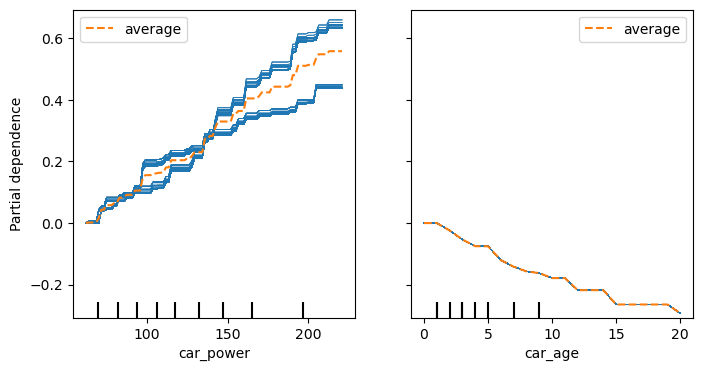

In [17]:
fig, axes = plt.subplots(figsize=(8, 4))

_ = PartialDependenceDisplay.from_estimator(
    LogRegressor(model_mc), 
    X_explain, 
    features=["car_power", "car_age"],
    kind="both",
    centered=True,
    ax=axes,
)

**Comments** 

- SHAP plots: Perfect monotonicity visible only for *additive* features.
- PDP and ICE: Curves perfectly monotonic (with or without interactions).

### Implementation details

In order to get a boosted tree model to predict monotonically in a feature $X_j$ it suffices to ensure that every single tree is monotonic in $X_j$.  
For a single tree there are two parts to consider:
1. Every split on $X_j$ has to respect the monotonicity   
2. And: Subsequent splits (on any feature) have to respect the monotonicity.

The first part is solved with the gain of a potential split on $X_j$. If the monotonicity constraint is violated then [the gain](https://github.com/scikit-learn/scikit-learn/blob/a33ade3decd853dfaaf787603289b23a355495ec/sklearn/ensemble/_hist_gradient_boosting/splitting.pyx#L1116) is set to -1.  

How do subsequent splits respect monotonicity? Capping logic:

![Capping logic](monotonic_constraint.PNG)

The lower and upper bounds for subsequent splits are calculated in the [tree grower](https://github.com/scikit-learn/scikit-learn/blob/7f9bad99d6e0a3e8ddf92a7e5561245224dab102/sklearn/ensemble/_hist_gradient_boosting/grower.py#L541)
and the capping is done when computing the [node values](https://github.com/scikit-learn/scikit-learn/blob/a33ade3decd853dfaaf787603289b23a355495ec/sklearn/ensemble/_hist_gradient_boosting/splitting.pyx#L1167) of a split.  

### Monotonic constraints gone wrong

- Define them correctly!
- And keep in mind: Monotonicity is Ceteris Paribus.

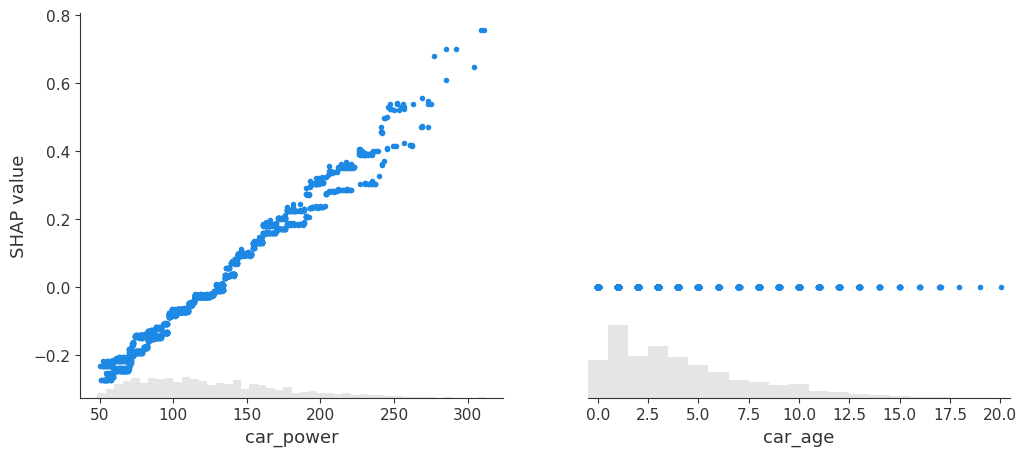

In [18]:
params_mc2 = params_ic | {"monotone_constraints": [0, 0, 0, 0, 1, 1]}  # Oops

model_mc2 = LGBMRegressor(n_estimators=num_rounds, **params_mc2)
model_mc2.fit(X_train, y_train)

explainer_mc2 = shap.Explainer(model_mc2)
shap_val_mc2 = explainer_mc2(X_explain)

shap.plots.scatter(shap_val_mc2[:, [4, 5]])